In [41]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
os.chdir("/Users/titouanhoude/Deep Learning/Post-hurricane/")
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [42]:
#train and test data directory
data_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/train_another"
test_data_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/test_another"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [43]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [44]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['damage', 'no_damage']


Label : damage


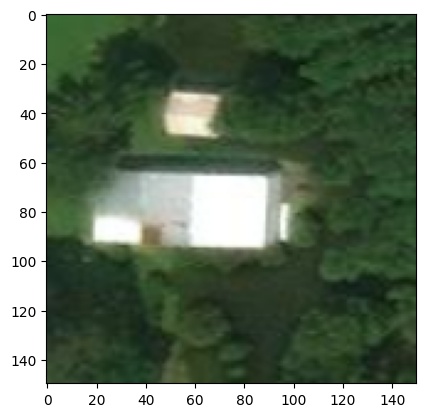

In [45]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[1])

In [46]:

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 20
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_data, batch_size , pin_memory = True)

Length of Train Data : 8000
Length of Validation Data : 2000


In [47]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(batch):
        images, labels = batch 
        out = images                # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(ImageClassificationBase):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3))
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, (3,3))
        self.conv3 = nn.Conv2d(64, 128, (3,3))
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = ConvNet()

In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        max_step = 100
        step = 0
        for batch in train_loader:
            if step >= max_step:
                break
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step +=1
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [50]:
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

TypeError: training_step() takes 1 positional argument but 2 were given

In [11]:
import pandas as pd
csvfile = pd.DataFrame(history)
csvfile.to_csv("Cnnres.csv", index=False, header=True)

NameError: name 'history' is not defined

In [12]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

NameError: name 'history' is not defined

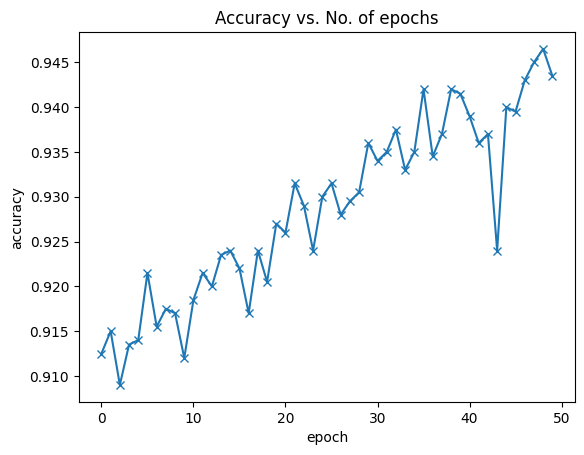

In [119]:
plot_accuracies(history)

In [55]:
from torch.optim import lr_scheduler
import torch.optim as optim

weights_DS = torchvision.models.MobileNet_V3_Small_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.mobilenet_v3_small(weights=weights_DS).to(device)

#weights_DS = torchvision.models.DenseNet169_Weights.DEFAULT
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = torchvision.models.densenet169(weights=weights_DS).to(device)

# Get the length of class_names (one output unit for each class)
output_shape = len(dataset.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=576, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# 3. Préparer les données d'entraînement
transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='/Users/titouanhoude/Deep Learning/Post-hurricane/train_another/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4. Définir une fonction de coût et un optimiseur
#model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 5. Entraîner le modèle
for epoch in range(20):  # nombre d'époques
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

print('Finished Training')

# 6. Évaluer le modèle
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

[Epoch 1] loss: 0.266


KeyboardInterrupt: 

In [81]:
import pandas as pd
columns = ["model", "correct", "total"]

#mod_pretrain = "mobilenet_v3_small"
mod_pretrain = "densenet169"

liste = [[mod_pretrain, correct,total]]
pre_train = pd.DataFrame(liste, columns=columns)

pre_train.to_csv("Pre_train.csv", index = False, header = True)

In [58]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# Image transforms
scaler = transforms.Resize((150, 150))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding.numpy()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
features = []
totaldir = []

damage_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/train_another/damage/"
damage = os.listdir(damage_dir)
for i in damage :
    totaldir.append(str(damage_dir + i))

no_damage_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/train_another/no_damage/"
no_damage = os.listdir(no_damage_dir)
for i in no_damage :
    totaldir.append(str(no_damage_dir + i))

#index = totaldir.index("/Users/titouanhoude/Deep Learning/Post-hurricane/train_another/damage/.DS_Store")
#totaldir.pop(index)

for dir in totaldir : 
    features.append(get_vector(dir))

features = pd.DataFrame(features)
features.to_csv("extract_features__on_train_another_from_resnet18.csv")

NameError: name 'pd' is not defined

In [46]:
import numpy as np
Mfeatures = np.array(features)

y = []
for i in range(10000): 
    if i <5000:
        y.append("damage")
    else : 
        y.append("no_damage")

from sklearn.neighbors import KNeighborsClassifier
# Initialize the model
pred_model = KNeighborsClassifier(n_neighbors=5)

# Fit the data into the model
pred_model.fit(Mfeatures, y)

In [65]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(features, y)

NameError: name 'features' is not defined

In [55]:
RdM_pred = clf.predict(pred)

In [64]:
pred_features = []
pred_totaldir = []
ytrue = []

damage_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/test/damage/"
damage = os.listdir(damage_dir)
for i in damage :
    pred_totaldir.append(str(damage_dir + i))

no_damage_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/test/no_damage/"
no_damage = os.listdir(no_damage_dir)
for i in no_damage :
    pred_totaldir.append(str(no_damage_dir + i))

i = 0 

for dir in pred_totaldir :
    pred_features.append(get_vector(dir))
    if i <1000:
        ytrue.append("damage")
    else :
        ytrue.append("no_damage")
    i+=1

In [ ]:
pred_unbalanced_features = []
pred_unbalanced_totaldir = []
ytrue_unbalanced = []

damage_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/test_another/damage/"
damage = os.listdir(damage_dir)
for i in damage :
    pred_unbalanced_totaldir.append(str(damage_dir + i))

no_damage_dir = "/Users/titouanhoude/Deep Learning/Post-hurricane/test_another/no_damage/"
no_damage = os.listdir(no_damage_dir)
for i in no_damage :
    pred_unbalanced_totaldir.append(str(no_damage_dir + i))

i = 0 

for dir in pred_unbalanced_totaldir :
    pred_unbalanced_features.append(get_vector(dir))
    if i <8000:
        ytrue_unbalanced.append("damage")
    else :
        ytrue_unbalanced.append("no_damage")
    i+=1

In [56]:
import pandas as pd
pred = pd.DataFrame(pred_features)

ypred = pred_model.predict(pred)

from sklearn.metrics import classification_report
target_names = ["damage", "no_damage"]

print(classification_report(ytrue, RdM_pred, target_names=target_names))

              precision    recall  f1-score   support

      damage       0.99      0.88      0.93      8000
   no_damage       0.50      0.92      0.64      1000

    accuracy                           0.89      9000
   macro avg       0.74      0.90      0.79      9000
weighted avg       0.93      0.89      0.90      9000



In [59]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytrue, RdM_pred)

array([[7073,  927],
       [  84,  916]])